# Uncover the factors to help measure how young children learn

### Setting Up

In [3]:
# System management
import os
import gc

# Numpy and pandas for data analysis and manipulation
import numpy as np
import pandas as pd

# Json for converting string to dict
import json

# Random for random
import random

# Datetime for handling date time variables
import datetime as dt

# Matplotlib pyplot and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Algorithms
from sklearn.ensemble import RandomForestClassifier as rf
from xgboost import XGBClassifier as xgb
from lightgbm import LGBMClassifier as lgbm
from lightgbm import LGBMRegressor

# Sklearn importing folding methods
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold
from sklearn.preprocessing import LabelEncoder

# Sklearn importing evaluation metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score, confusion_matrix

# For shuffling Groups
from sklearn.utils import shuffle

# Hyper paramater optimisation
from hyperopt import hp, tpe, Trials, STATUS_OK
from hyperopt.fmin import fmin

# Weights and Biases for model control
import wandb

# tqdm for progress management
from tqdm import tqdm
tqdm.pandas()

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

C:\Users\jakec\AppData\Local\Continuum\anaconda3\envs\early-chieldhood-education\lib\site-packages\tqdm\std.py:651: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
# Setting up
config = {
    'method': 'LightGBM',
    'debug': False,
    'debug_train_size': 100,
    'debug_test_size': 50,
    'random_seed': 42,
    'num_trials': 10
}

### Functions

In [5]:
def ml_encoder(train, test, encode_columns, threshold=999, nan_as_category=True):
    """
    One-hot and label encoder with thresholds for categorical columns
    """
    # Union train and test to make sure all categories are represented
    df = pd.concat([train, test], ignore_index=True)
    
    # Unchanged columns
    keep_df = df[df.columns[~df.columns.isin(encode_columns)]]

    # Number of categories
    num_categories = df[encode_columns].describe(include='all').loc['unique']
    
    # Label encoding
    label_columns = num_categories.where(num_categories >= threshold).dropna().index
    le = LabelEncoder()
    label_df = df[label_columns].apply(lambda col: le.fit_transform(col))

    # One hot encoding
    one_hot_columns = num_categories.where(num_categories < threshold).dropna().index
    one_hot_df = pd.get_dummies(df[one_hot_columns], dummy_na=nan_as_category)
    one_hot_df.columns = [f"{col}" for col in one_hot_df.columns]
    
    # Rebuild the dataframe
    df = pd.concat([keep_df, label_df, one_hot_df], axis=1, sort=True)
    
    train = df.iloc[:len(train.index)].reset_index().drop(columns=['index'])
    test = df.iloc[len(train.index):].reset_index().drop(columns=['index'])
    
    return train, test, le

In [6]:
def json_to_columns(train, test, json_columns):
    """
    Splits out json columns
    """
    # Union train and test to make sure all categories are represented
    df = pd.concat([train, test], ignore_index=True)
    
    # Base to make the new datafram from
    base_df = df[df.columns[~df.columns.isin(json_columns)]]

    for column in json_columns:
        json_df = pd.DataFrame(df[column].apply(json.loads).values.tolist())
        json_df = json_df.fillna(0).astype(int)
        json_df.columns = [f"{column}_{new_column}" for new_column in json_df.columns]
        base_df = pd.concat([base_df, json_df], axis=1)
    
    train = base_df.iloc[:len(train.index)].reset_index().drop(columns=['index'])
    test = base_df.iloc[len(train.index):].reset_index().drop(columns=['index'])
    
    return train, test

In [7]:
def accuracy_grouping(accuracy):
    if accuracy == 1:
        return 3
    elif accuracy == 0.5:
        return 2
    elif accuracy > 0:
        return 1
    elif accuracy == 0:
        return 0

### Imported Functions

In [8]:
# Using Ben Hamners quadratic weighted Kappa https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/quadratic_weighted_kappa.py
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Calculates the quadratic weighted kappa
    quadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator

### Importing Data

Can be commented out after the first run

In [9]:
# y_train = pd.read_csv("../data/train_labels.csv")
# # Saving full training set as feather
# y_train.reset_index().drop(columns = ['index']).to_feather("../data/y_train.feather")
# print(y_train.shape)
# # Creating sample for debuging
# sample = pd.Series(y_train['installation_id'].unique()).sample(config['debug_train_size'], random_state=config['random_seed'])
# y_train_sample = y_train.where(y_train['installation_id'].isin(sample)).dropna()
# y_train_sample.reset_index().drop(columns = ['index']).to_feather("../data/y_train_sample.feather")
# print(y_train_sample.shape)

In [8]:
# X_train = pd.read_csv("../data/train.csv")
# # Droping ids that never had an assessment
# assessed = y_train['installation_id']
# X_train = X_train.where(X_train['installation_id'].isin(assessed)).dropna()
# # Saving full training set as feather
# X_train.reset_index().drop(columns = ['index']).to_feather("../data/X_train.feather")
# print(X_train.shape)
# # Creating sample for config['debug']ing
# X_train_sample = X_train.where(X_train['installation_id'].isin(sample)).dropna()
# X_train_sample.reset_index().drop(columns = ['index']).to_feather("../data/X_train_sample.feather")
# print(X_train_sample.shape)

In [9]:
# X_test = pd.read_csv("../data/test.csv")
# # Saving full training set as feather
# X_test.reset_index().to_feather("../data/X_test.feather")
# print(X_test.shape)
# # Creating test sample for config['debug']ing
# test_sample = pd.Series(X_test['installation_id'].unique()).sample(config['debug_test_size'], random_state=config['random_seed'])
# X_test_sample = X_test.where(X_test['installation_id'].isin(test_sample)).dropna()
# X_test_sample.reset_index().drop(columns = ['index']).to_feather("../data/X_test_sample.feather")
# print(X_test_sample.shape)

In [10]:
# Loading training set from feather
if config['debug']:
    X_train = pd.read_feather("../data/X_train_sample.feather")
else:
    X_train = pd.read_feather("../data/X_train.feather")

In [11]:
# Loading target set from feather
if config['debug']:
    y_train = pd.read_feather("../data/y_train_sample.feather")
else:
    y_train = pd.read_feather("../data/y_train.feather")

In [12]:
# Loading testing set from feather
if config['debug']:
    X_test = pd.read_feather("../data/X_test_sample.feather")
else:
    X_test = pd.read_feather("../data/X_test.feather")

In [13]:
gc.collect()

73

## Feature Engineering

##### Creating features

In [14]:
X_train['datetime'] = [dt.replace(tzinfo=None) for dt in pd.to_datetime(X_train.timestamp)]
X_test['datetime'] = [dt.replace(tzinfo=None) for dt in pd.to_datetime(X_test.timestamp)]

In [15]:
# X_train['title.event_code'] = X_train[['title', 'event_code']].apply(lambda x: ''.join(str(x)), axis=1)
# X_test['title.event_code'] = X_train[['title', 'event_code']].apply(lambda x: ''.join(str(x)), axis=1)

In [16]:
X_train['assessed'] = (((X_train.type == 'Assessment') & (X_train.event_code == 4100)) 
                      | ((X_train.title == 'Bird Measurer (Assessment)') & (X_train.event_code == 4110)))
X_test['assessed'] = (((X_test.type == 'Assessment') & (X_test.event_code == 4100)) 
                      | ((X_test.title == 'Bird Measurer (Assessment)') & (X_test.event_code == 4110)))

##### Grouping into sessions

In [17]:
# For now just pulling out basic information
def session_information(df):
    # should look into event_data, event_id, time over each event, time to each event, time from each event, etc.
    session_df = pd.DataFrame([[df.installation_id.iloc[0]]], columns=['installation_id'])
#     session_df['game_session'] = df.game_session.iloc[0]
    session_df['type'] = df.type.iloc[0]
    session_df['title'] = df.title.iloc[0]
    session_df['session_title'] = df.title.iloc[0]
    session_df['session_num_event_code'] = json.dumps(df.groupby(['event_code']).count()['installation_id'].to_dict())
    session_df['session_num_event_id'] = json.dumps(df.groupby(['event_id']).count()['installation_id'].to_dict())
    session_df['session_event_count'] = df.event_count.max()
    session_df['session_start'] = df.datetime.min()
    session_df['session_end'] = df.datetime.max()
    session_df['session_length'] = df.game_time.max()
    session_df['session_avg_event_time'] = session_df.session_length / session_df.session_event_count
    session_df['session_hour'] = session_df.session_start.dt.hour.astype(str)
    session_df['session_day'] = session_df.session_start.dt.dayofyear
    session_df['session_weekday'] = session_df.session_start.dt.weekday.astype(str)
    # Assessed sessions
    session_df['assessed'] = df.assessed.any()
    session_df['num_correct'] = df.event_data.apply(lambda x: json.loads(x).get('correct')).sum()
    session_df['num_incorrect'] = df.event_data.apply(lambda x: json.loads(x).get('correct')).count() - session_df.num_correct
    session_df['accuracy'] = session_df.num_correct / (session_df.num_correct + session_df.num_incorrect)
    session_df['accuracy_grouping'] = session_df.accuracy.apply(lambda x: accuracy_grouping(x))
    
    return session_df

In [18]:
# Grouping up to a session level
X_train = X_train.groupby('game_session').progress_apply(session_information)
X_test = X_test.groupby('game_session').progress_apply(session_information)

100%|██████████| 28445/28445 [08:17<00:00, 57.19it/s]


In [19]:
X_train.sort_values(['session_start', 'game_session'], inplace=True)
X_test.sort_values(['session_start', 'game_session'], inplace=True)

In [20]:
X_train = X_train.reset_index().drop(columns='level_1')
X_test = X_test.reset_index().drop(columns='level_1')

In [21]:
X_train, X_test = json_to_columns(X_train, X_test, ['session_num_event_code', 'session_num_event_id'])

In [22]:
X_train, X_test, _ = ml_encoder(X_train, X_test, encode_columns=['type', 'title'], nan_as_category=False)

In [23]:
X_train.columns = [str(col) for col in X_train.columns]
X_test.columns = [str(col) for col in X_train.columns]

In [24]:
print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (175467, 528)
Test shape: (28445, 528)


In [25]:
# Saving to feather for fast loading from checkpoint
if config['debug']:
    X_train.to_feather("../data/X_train_sessions_sample.feather")
    X_test.to_feather("../data/X_test_sessions_sample.feather")
else:
    X_train.to_feather("../data/X_train_sessions.feather")
    X_test.to_feather("../data/X_test_sessions.feather")

In [10]:
# Saving to feather for fast loading from checkpoint
if config['debug']:
    X_train = pd.read_feather("../data/X_train_sessions_sample.feather")
    X_test = pd.read_feather("../data/X_test_sessions_sample.feather")
else:
    X_train = pd.read_feather("../data/X_train_sessions.feather")
    X_test = pd.read_feather("../data/X_test_sessions.feather")
gc.collect()

7

##### Grouping into assessment events

In [11]:
def get_rolling_amount(grp, freq):
    return grp.rolling(freq, on='session_start').session_event_count.count()

In [12]:
def installation_information(df, test_set=False):
    # Columns to sum count over
    cumulative_columns = [col for col in df.columns if ('event_code_' in col or 
                                                        'event_id_' in col or 
                                                        'title_' in col or 
                                                        'type_' in col or 
                                                        col in ('session_event_count', 'session_length', 'num_correct', 
                                                                'num_incorrect', 'accuracy', 'accuracy_grouping', 'assessed'))]

    cumulative_df = df[cumulative_columns + ['installation_id']].groupby('installation_id').cumsum()
    cumulative_df.columns = [f"cumulative_{col}" for col in cumulative_df.columns]
    
    # Removing counts from the assessed session (they're truncated in the test set)
    for col in cumulative_columns:
        cumulative_df[f"cumulative_{col}"] = cumulative_df[f"cumulative_{col}"] - df[col]
    
    # Getting count of sessions
    cumulative_df['num_sessions'] = df.groupby('installation_id').game_session.cumcount()
        
    # Ratios
    cumulative_df['average_event_time'] = cumulative_df.cumulative_session_length / cumulative_df.num_sessions
    cumulative_df['average_event_count'] = cumulative_df.cumulative_session_event_count / cumulative_df.num_sessions
    cumulative_df['average_num_correct'] = cumulative_df.cumulative_num_correct / cumulative_df.cumulative_assessed
    cumulative_df['average_accuracy'] = cumulative_df.cumulative_accuracy / cumulative_df.cumulative_assessed
    cumulative_df['total_accuracy'] = cumulative_df.cumulative_num_correct / (cumulative_df.cumulative_num_correct + cumulative_df.cumulative_num_incorrect)
    cumulative_df['average_accuracy_grouping'] = cumulative_df.cumulative_accuracy_grouping / cumulative_df.cumulative_assessed
    
    # Dabbling with temporal features
    # Time since last session
    cumulative_df['time_last_session'] = (df.groupby('installation_id').session_start.shift(1) - df.session_start).astype(np.int64)
    # Number of sessions in past period
    cumulative_df['num_sessions_past_month'] = df.groupby('installation_id', as_index=False, group_keys=False).apply(get_rolling_amount, '30D')
    cumulative_df['num_sessions_past_week'] = df.groupby('installation_id', as_index=False, group_keys=False).apply(get_rolling_amount, '7D')
    cumulative_df['num_sessionspast_day'] = df.groupby('installation_id', as_index=False, group_keys=False).apply(get_rolling_amount, '1D')
    cumulative_df['num_sessionspast_hour'] = df.groupby('installation_id', as_index=False, group_keys=False).apply(get_rolling_amount, '1H')
    
    drop_columns = [col for col in df.columns if ('event_code_' in col or 'event_id_' in col)]
    df = df.drop(columns = drop_columns)
    
    # Build the aggregated dataframe
    df = pd.concat([df, cumulative_df], axis=1, sort=True)
    
    if test_set:
        df = df.loc[df.groupby('installation_id').session_start.idxmax()]
    else:
        df = df[df.assessed]
    
    return df

In [13]:
X_train = installation_information(X_train)
X_test = installation_information(X_test, test_set=True)

##### Additional Data Prep

In [14]:
# Removing test events that are not part of the kaggle compitition
X_test = X_test.loc[X_test.groupby('installation_id').session_start.idxmax()]

In [15]:
# Encoding
X_train, X_test, le = ml_encoder(X_train, X_test, encode_columns=['session_title', 'session_hour', 'session_weekday'], nan_as_category=False)

In [16]:
# Quick way to allign index
y_train = X_train.accuracy_grouping.astype(int)

In [17]:
# Drop columns thatwon't be helpful or that we wont have in the test set
drop_columns = ['session_start', 'session_end', 'accuracy_grouping', 'assessed', 'num_correct', 'num_incorrect', 'accuracy', 'game_session'
                , 'session_avg_event_time', 'session_event_count', 'session_length']
X_train.drop(columns = drop_columns, inplace=True)
X_test.drop(columns = drop_columns, inplace=True)

In [18]:
print("train shape:", (len(X_train.index), len(X_train.columns)))
print("train target:", (len(y_train.index)))
print("test shape:", (len(X_test.index), len(X_test.columns)))

train shape: (17692, 618)
train target: 17692
test shape: (1000, 618)


## Creating a baseline fit with basic data to prep the model

In [19]:
# Setting up a sweep config for wandb sweeps (hyper paramater tuning)
# sweep_config = {
#     'method': 'bayes', #grid, random
#     'metric': {
#       'name': 'cappa',
#       'goal': 'maximize'   
#     },
#     'parameters': {
#         'num_folds': [10, 11],
#         'num_leaves': [32],
#         'max_depth': [10],
#         'learning_rate': [0.001],
#         'num_boosting_round': 2000,
#         'metric': ['cappa', 'rmse'],
#         'verbose': [-1],
#         'subsample': [0.97],
#         'colsample_bytree': [0.95],
#         'random_state': [42],
#         'min_child_samples': [11]
#     }
# }
# sweep_id = wandb.sweep(sweep_config, entity="sweep")

In [20]:
def fit_lgbm(params, X_train_=X_train, X_test_=X_test, y_train_=y_train):
    wandb.init()
    params = {
        'boosting_type': params['boosting_type'],
        'num_folds': int(params['num_folds']),
        'num_leaves': int(params['num_leaves']),
        'max_depth': int(params['max_depth']),
        'learning_rate': params['learning_rate'],
        'num_boosting_round': int(params['num_boosting_round']),
        'metric': params['metric'],
        'verbose': params['verbose'],
        "subsample": params['subsample'],
        "colsample_bytree": params['colsample_bytree'],
        "random_state": int(params['random_state']),
        'min_child_samples': int(params['min_child_samples'])
    }
    
    # Get folds - this should be updated to grouped k fold
    num_folds = int(params['num_folds'])
    installation_ids = np.array(sorted(X_train_['installation_id']))
    
    # Setting up folds grouped by installation_id
    folds = []
    GroupKfolds = GroupKFold(n_splits=num_folds)
    for train, valid in GroupKfolds.split(X=X_train_, groups=X_train_.installation_id):
        folds.append([train, valid])
        
    # Dropping installation_id
    X_train_ = X_train_.drop(columns=['installation_id'])
    X_test_ = X_test_.drop(columns=['installation_id'])

    
    # Initializing Variables
    prd_train = pd.Series(np.zeros(y_train_.shape[0]))
    prd_test = np.zeros(X_test_.shape[0])
    imp = pd.DataFrame()
    MSE = 0
    avg_kappa = 0

    for n_fld, (trn_idx, vld_idx) in enumerate(folds):
        #trn_idx = idx_tab.iloc[trn_num].index
        #vld_idx = idx_tab.iloc[vld_num].index
        X_train__, y_train__ = X_train_.iloc[trn_idx], y_train_.iloc[trn_idx]
        X_valid, y_valid = X_train_.iloc[vld_idx], y_train_.loc[vld_idx]

        lgb = LGBMRegressor(**params)

        # Fit the model
        lgb.fit(X_train__, y_train__)

        # applying the model to the validation data
        prd_valid = lgb.predict(X_valid)
        # Calculating and outputting the RMSE
        y_valid = np.array(y_valid.astype(int))
        prd_valid = np.array(np.round_(np.floor(prd_valid), decimals=0).astype(int))
        fld_MSE = (np.square(y_valid - prd_valid)).mean()
        fld_QWK = quadratic_weighted_kappa(y_valid, prd_valid)
        wandb.log({'fold_RMSE': fld_MSE, 'fold_kappa': fld_QWK}, step=n_fld + 1)
        # Summing mean squared errors
        MSE += fld_MSE/num_folds

        # Applying predictions to the train set weighted by the MSE
        prd = lgb.predict(X_valid)
        prd = np.array(np.round_(prd, decimals=0).astype(int))
        prd_train.iloc[vld_idx] = prd

        # Applying predictions to the test set weighted by the MSE
        prd = lgb.predict(X_test_)
        prd_test += prd/num_folds

        # Calculating the fold importance
        imp_df = pd.DataFrame()
        imp_df['fts'] = X_train__.columns
        imp_df['imp'] = lgb.booster_.feature_importance(importance_type='gain')

        # Summing the fold importances
        imp_df['fld'] = n_fld+1
        imp = pd.concat([imp, imp_df], axis=0, sort=False)
        gc.collect()
        
    Importances = imp[["fts", "imp"]].groupby("fts").mean().sort_values(by="imp", ascending=False)[:60]

    wandb.log({"Importances": wandb.Table(data=Importances.reset_index().values.tolist(), columns=['Fetures', 'Importances'])})
    wandb.log(config)
    wandb.log(params)
    wandb.log({'RMSE': np.sqrt(MSE), 'kappa': quadratic_weighted_kappa(y_train_, prd_train)})
    
    return {'loss': -quadratic_weighted_kappa(y_train_, prd_train), 'status': STATUS_OK, 'other_stuff': {'Importance': Importances.to_dict(), 'Best_Prediction': prd_test}}

In [21]:
param_space = {
    'boosting_type': hp.choice('boosting_type', ['gbdt']),
    'num_folds': 5, # hp.quniform('num_folds', 4, 11, 1),
    'num_leaves': 31, # hp.quniform('num_leaves', 30, 33, 1),
    'max_depth': 17, # hp.quniform('max_depth', 15, 19, 1),
    'learning_rate': 0.10228392552169215, # hp.loguniform('learning_rate', np.log(0.02), np.log(0.5)),
    'num_boosting_round': 7143, # hp.loguniform('learning_rate', np.log(500), np.log(10000)),
    'metric': 'cappa', # hp.choice('metric', ['cappa', 'rmse']),
    'verbose': -1,
    'subsample': hp.loguniform('subsample', np.log(0.95), np.log(1)), # 0.9636096100279673,
    'colsample_bytree': hp.loguniform('colsample_bytree', np.log(0.5), np.log(1)), # 0.666624460958229,
    'random_state': 42,
    'min_child_samples': 17 # hp.quniform('min_child_samples', 5, 20, 1)
}

In [22]:
# Hyperparameter optimisation
# wandb.agent(sweep_id, function=train)
trials = Trials()
best = fmin(fn=fit_lgbm, space=param_space, algo=tpe.suggest, max_evals=config['num_trials'], trials=trials, verbose=1)

  0%|          | 0/10 [00:00<?, ?it/s, best loss: ?]

 10%|█         | 1/10 [00:15<02:18, 15.44s/it, best loss: -0.4737373324609041]

 20%|██        | 2/10 [00:30<02:02, 15.35s/it, best loss: -0.4737373324609041]

 30%|███       | 3/10 [00:48<01:51, 15.98s/it, best loss: -0.47458003298791895]

 40%|████      | 4/10 [01:05<01:38, 16.40s/it, best loss: -0.47458003298791895]

 50%|█████     | 5/10 [01:22<01:22, 16.59s/it, best loss: -0.47720515936867347]

 60%|██████    | 6/10 [01:39<01:06, 16.66s/it, best loss: -0.47720515936867347]

 70%|███████   | 7/10 [01:57<00:51, 17.28s/it, best loss: -0.47720515936867347]

 80%|████████  | 8/10 [02:15<00:34, 17.44s/it, best loss: -0.47720515936867347]

 90%|█████████ | 9/10 [02:35<00:18, 18.15s/it, best loss: -0.47720515936867347]

100%|██████████| 10/10 [02:55<00:00, 17.50s/it, best loss: -0.47720515936867347]


In [ ]:
best_kappa = 0
best_trial = None
for trial in trials.results:
    if best_kappa < -trial['loss']:
        best_trial = trial

In [29]:
# Initializing lgbm paramaters
params = {
    'boosting_type': 'gbdt',
    'num_folds': 5,
    'num_leaves': 31,
    'max_depth': 17,
    'learning_rate': 0.10228392552169215,
    'num_boosting_round': 7143,
    'metric': 'cappa',
    'verbose': 1,
    "subsample": 0.9636096100279673,
    "colsample_bytree": 0.666624460958229,
    "random_state": 42,
    'min_child_samples': 17
}

In [30]:
best_trial = fit_lgbm(params, X_train_=X_train, X_test_=X_test, y_train_=y_train)

In [31]:
Importances = pd.DataFrame(list(best_trial['other_stuff']['Importance']['imp'].items()), columns=['Feature', 'Importance'])

Text(0.5, 1.0, 'Features (avg over folds)')

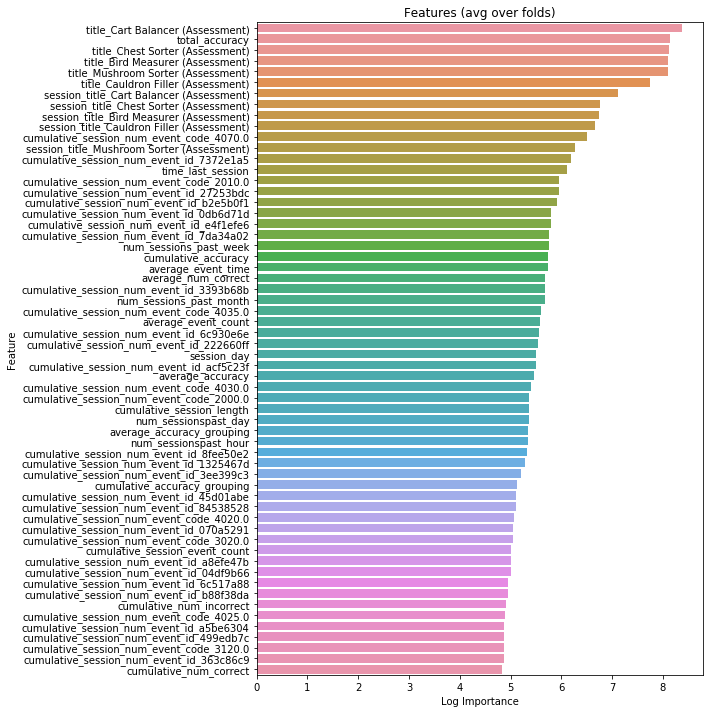

In [32]:
# Ploting feature importances
Importances['Log Importance'] = np.log1p(Importances['Importance'])
plt.figure(figsize=(8, 12))
sns.barplot(x="Log Importance", y="Feature", data=Importances.sort_values(by="Importance", ascending=False))
plt.title('Features (avg over folds)')

In [49]:
submission_df = pd.DataFrame({'installation_id': X_test.installation_id, 'accuracy_group': best_trial['other_stuff']['Best_Prediction']})

In [50]:
submission_df.to_csv("../data/submission.csv", index=False)

In [53]:
# !kaggle competitions submit -c data-science-bowl-2019 -f "../data/submission.csv" -m "First submission unrounded accuracy_grouping"

403 - This competition only allows kernel submissions.



  0%|          | 0.00/28.1k [00:00<?, ?B/s]
 28%|##8       | 8.00k/28.1k [00:00<00:00, 44.6kB/s]
100%|##########| 28.1k/28.1k [00:12<00:00, 2.34kB/s]
